<a href="https://colab.research.google.com/github/KimEulJoong/Project_AI_Parking_Lot/blob/parking_space/Detect_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'

Mounted at /content/drive


In [ ]:
import zipfile
import os

extract_path = '/content/pklot'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ 압축 해제 완료:", extract_path)

# 압축 해제 후 구조 확인
import os

for split in ['train', 'valid', 'test']:
    split_path = os.path.join(extract_path, split)
    images = os.listdir(split_path)
    print(f"{split} set: {len(images)} files")


✅ 압축 해제 완료: /content/pklot
train set: 8692 files
valid set: 2484 files
test set: 1243 files


In [ ]:
# python으로 직접 COCO -> YOLO 형식 변환
!pip install -q fiftyone

import json
import os
from tqdm import tqdm

def convert_coco_to_yolo(json_path, images_dir, labels_dir, class_names):
    os.makedirs(labels_dir, exist_ok=True)

    with open(json_path) as f:
        data = json.load(f)

    # COCO에서 class_id → class_name 매핑
    id2name = {cat['id']: cat['name'] for cat in data['categories']}
    name2id = {v: i for i, v in enumerate(class_names)}

    for img in tqdm(data['images']):
        img_id = img['id']
        img_filename = img['file_name']
        width = img['width']
        height = img['height']
        label_path = os.path.join(labels_dir, img_filename.replace('.jpg', '.txt'))

        with open(label_path, 'w') as label_file:
            for ann in data['annotations']:
                if ann['image_id'] != img_id:
                    continue
                cat_name = id2name[ann['category_id']]
                class_id = name2id[cat_name]
                x, y, w, h = ann['bbox']
                xc = (x + w / 2) / width
                yc = (y + h / 2) / height
                w /= width
                h /= height
                label_file.write(f"{class_id} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

    print(f"✅ 변환 완료: {labels_dir}")


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.3/306.3 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.0/943.0 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 12.4 MB/s eta 0

In [ ]:
with open(json_path) as f:
    data = json.load(f)

category_names = [cat['name'] for cat in data['categories']]
print("✅ COCO 라벨 클래스들:", category_names)


✅ COCO 라벨 클래스들: ['spaces', 'space-empty', 'space-occupied']


In [ ]:
json_path = "/content/pklot/train/_annotations.coco.json"
images_dir = "/content/pklot/train"
labels_dir = "/content/pklot/labels/train"

class_names = ['spaces', 'space-empty', 'space-occupied']  # 또는 정확한 클래스 이름

convert_coco_to_yolo(json_path, images_dir, labels_dir, class_names)

100%|██████████| 8691/8691 [06:15<00:00, 23.17it/s]


✅ 변환 완료: /content/pklot/labels/train


In [ ]:
# pklot 하위 test 디렉토리 또한 경로 재설정 후 coco->yolo convert
# 1. 필요한 경로 설정
json_path = "/content/pklot/test/_annotations.coco.json"
images_dir = "/content/pklot/test"
labels_dir = "/content/pklot/labels/test"

# 2. 클래스 이름 (train과 동일하게 사용)
class_names = ['spaces', 'space-empty', 'space-occupied']

# 3. YOLO 형식으로 라벨 변환
convert_coco_to_yolo(json_path, images_dir, labels_dir, class_names)


100%|██████████| 1242/1242 [00:05<00:00, 226.79it/s]

✅ 변환 완료: /content/pklot/labels/test


In [ ]:
# 마지막으로 valid에 해당하는 디렉토리 설정
# valid 라벨 변환
json_path = "/content/pklot/valid/_annotations.coco.json"
images_dir = "/content/pklot/valid"
labels_dir = "/content/pklot/labels/valid"

class_names = ['spaces', 'space-empty', 'space-occupied']  # train과 동일

convert_coco_to_yolo(json_path, images_dir, labels_dir, class_names)


100%|██████████| 2483/2483 [00:30<00:00, 81.03it/s]


✅ 변환 완료: /content/pklot/labels/valid


In [ ]:
#pklot_yolo 에 test 만들어주고 해당 디렉토리 완성
import os
import shutil

def prepare_yolo_dataset():
    base = "/content/pklot"
    target = "/content/pklot_yolo"

    for split in ['train', 'valid', 'test']:  # ✅ test 포함!
        # 이미지 경로 설정
        image_src = os.path.join(base, split)
        image_dst = os.path.join(target, "images", split)
        os.makedirs(image_dst, exist_ok=True)

        # 이미지 복사
        for f in os.listdir(image_src):
            if f.endswith('.jpg'):
                shutil.copy(os.path.join(image_src, f), os.path.join(image_dst, f))

        # 라벨 경로 설정
        label_src = os.path.join(base, "labels", split)
        label_dst = os.path.join(target, "labels", split)
        os.makedirs(label_dst, exist_ok=True)

        # 라벨 복사
        if os.path.exists(label_src):
            for f in os.listdir(label_src):
                if f.endswith('.txt'):
                    shutil.copy(os.path.join(label_src, f), os.path.join(label_dst, f))
        else:
            print(f"⚠️ 라벨 디렉토리 없음: {label_src} → 생략됨")

    print("✅ YOLOv8 학습용 디렉토리 완성됨: /content/pklot_yolo")

prepare_yolo_dataset()


✅ YOLOv8 학습용 디렉토리 완성됨: /content/pklot_yolo


In [ ]:
yaml_content = """\
path: /content/pklot_yolo
train: images/train
val: images/valid
test: images/test

nc: 3
names: ['spaces', 'space-empty', 'space-occupied']
"""

with open("/content/pklot_yolo.yaml", "w") as f:
    f.write(yaml_content)

print("✅ yaml 파일 생성 완료: pklot_yolo.yaml")


✅ yaml 파일 생성 완료: pklot_yolo.yaml


In [ ]:
!pip install ultralytics

from ultralytics import YOLO

# 모델 정의
model = YOLO("yolov8n.yaml")  # 처음부터 학습하거나
# model = YOLO("yolov8n.pt")  # 사전학습된 모델을 fine-tuning할 수도 있음

# 학습
model.train(data="/content/pklot_yolo.yaml", epochs=50, imgsz=640)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

100%|██████████| 755k/755k [00:00<00:00, 23.4MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 96.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 23.2±5.9 MB/s, size: 61.2 KB)


train: Scanning /content/pklot_yolo/labels/train... 8691 images, 189 backgrounds, 0 corrupt: 100%|██████████| 8691/8691 [00:25<00:00, 345.18it/s]


train: New cache created: /content/pklot_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 15.6±4.9 MB/s, size: 66.2 KB)


val: Scanning /content/pklot_yolo/labels/valid... 2483 images, 59 backgrounds, 0 corrupt: 100%|██████████| 2483/2483 [00:07<00:00, 334.68it/s]

val: New cache created: /content/pklot_yolo/labels/valid.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.29G      3.353      2.208      2.632         81        640: 100%|██████████| 544/544 [02:54<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:30<00:00,  2.57it/s]


                   all       2483     143316       0.81      0.845      0.879      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       7.1G      1.595     0.9403      1.317        366        640: 100%|██████████| 544/544 [02:44<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:26<00:00,  2.92it/s]


                   all       2483     143316       0.91      0.944      0.951       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.11G      1.309     0.7514      1.144        291        640: 100%|██████████| 544/544 [02:42<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:26<00:00,  2.94it/s]


                   all       2483     143316      0.942      0.964      0.974      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.93G      1.165     0.6645      1.075        235        640: 100%|██████████| 544/544 [02:44<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.04it/s]


                   all       2483     143316      0.958      0.969      0.977      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.78G      1.051     0.5979      1.024        311        640: 100%|██████████| 544/544 [02:42<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:26<00:00,  2.96it/s]


                   all       2483     143316       0.96      0.971      0.978      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.79G      0.981     0.5668     0.9939        348        640: 100%|██████████| 544/544 [02:42<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:27<00:00,  2.85it/s]


                   all       2483     143316      0.961      0.973      0.981      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       5.8G     0.9185     0.5323     0.9726        110        640: 100%|██████████| 544/544 [02:41<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.02it/s]


                   all       2483     143316      0.961      0.974      0.982       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.82G     0.8838     0.5095     0.9566        217        640: 100%|██████████| 544/544 [02:42<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.06it/s]


                   all       2483     143316      0.963      0.974      0.985       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.84G     0.8433     0.4921     0.9432         67        640: 100%|██████████| 544/544 [02:44<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.05it/s]


                   all       2483     143316      0.964      0.974      0.986       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.85G     0.8136     0.4782     0.9324        168        640: 100%|██████████| 544/544 [02:42<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.06it/s]


                   all       2483     143316      0.964      0.975      0.988      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.87G      0.787      0.465     0.9252        190        640: 100%|██████████| 544/544 [02:41<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:27<00:00,  2.88it/s]


                   all       2483     143316      0.966      0.973      0.989      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.89G      0.759     0.4516     0.9139        216        640: 100%|██████████| 544/544 [02:41<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.15it/s]

                   all       2483     143316      0.959      0.984       0.99      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       5.9G     0.7444     0.4445     0.9086        226        640: 100%|██████████| 544/544 [02:41<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.05it/s]


                   all       2483     143316      0.958      0.986      0.992      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.92G     0.7255     0.4368     0.9044        221        640: 100%|██████████| 544/544 [02:39<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:26<00:00,  2.91it/s]

                   all       2483     143316       0.97      0.981      0.992      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.94G     0.7057     0.4232      0.898        224        640: 100%|██████████| 544/544 [02:39<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]

                   all       2483     143316      0.978      0.972      0.992       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.96G     0.6915     0.4139     0.8944        381        640: 100%|██████████| 544/544 [02:40<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.07it/s]


                   all       2483     143316      0.983      0.979      0.993      0.897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.97G     0.6773     0.4067     0.8882        102        640: 100%|██████████| 544/544 [02:41<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.06it/s]

                   all       2483     143316      0.983      0.986      0.993      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.99G     0.6667      0.398     0.8857        365        640: 100%|██████████| 544/544 [02:41<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.07it/s]

                   all       2483     143316      0.983      0.979      0.993      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.01G     0.6572     0.3919     0.8838        167        640: 100%|██████████| 544/544 [02:40<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]

                   all       2483     143316      0.987      0.986      0.994      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.02G     0.6465     0.3924     0.8809        122        640: 100%|██████████| 544/544 [02:39<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.21it/s]


                   all       2483     143316      0.987      0.989      0.994      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.04G     0.6323     0.3831     0.8751        400        640: 100%|██████████| 544/544 [02:39<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]


                   all       2483     143316      0.983      0.981      0.994      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.06G     0.6254     0.3748     0.8749        178        640: 100%|██████████| 544/544 [02:40<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.16it/s]

                   all       2483     143316      0.984      0.979      0.994      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.08G     0.6136     0.3699     0.8706        263        640: 100%|██████████| 544/544 [02:39<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.16it/s]

                   all       2483     143316      0.989       0.99      0.994      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.09G     0.6063     0.3641     0.8691        204        640: 100%|██████████| 544/544 [02:41<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.08it/s]

                   all       2483     143316      0.988      0.989      0.994      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.11G     0.5983     0.3611      0.867        248        640: 100%|██████████| 544/544 [02:40<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.12it/s]

                   all       2483     143316      0.989      0.992      0.994      0.927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.12G     0.5877     0.3523     0.8635        204        640: 100%|██████████| 544/544 [02:42<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:26<00:00,  2.95it/s]

                   all       2483     143316       0.99       0.99      0.994      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.14G     0.5832     0.3494     0.8636        150        640: 100%|██████████| 544/544 [02:42<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.08it/s]

                   all       2483     143316      0.992      0.993      0.994      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.16G     0.5797      0.349      0.862        118        640: 100%|██████████| 544/544 [02:43<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.15it/s]

                   all       2483     143316      0.994      0.995      0.994      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.18G     0.5701     0.3413     0.8594        245        640: 100%|██████████| 544/544 [02:45<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.20it/s]

                   all       2483     143316      0.994      0.994      0.994      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.19G     0.5652     0.3341     0.8585        109        640: 100%|██████████| 544/544 [02:43<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.13it/s]

                   all       2483     143316      0.995      0.995      0.994      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.21G     0.5544     0.3324     0.8557        488        640: 100%|██████████| 544/544 [02:43<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.18it/s]

                   all       2483     143316      0.995      0.995      0.994       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.23G      0.551     0.3281     0.8546         71        640: 100%|██████████| 544/544 [02:43<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:26<00:00,  2.99it/s]


                   all       2483     143316      0.995      0.995      0.994      0.939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.24G     0.5443     0.3265     0.8526        158        640: 100%|██████████| 544/544 [02:41<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.08it/s]

                   all       2483     143316      0.995      0.996      0.994      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.26G     0.5359     0.3209     0.8511        109        640: 100%|██████████| 544/544 [02:41<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.17it/s]

                   all       2483     143316      0.995      0.995      0.994      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.28G     0.5348     0.3233     0.8501         86        640: 100%|██████████| 544/544 [02:43<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.15it/s]

                   all       2483     143316      0.996      0.997      0.994      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.29G     0.5319     0.3192     0.8497        220        640: 100%|██████████| 544/544 [02:44<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:23<00:00,  3.26it/s]

                   all       2483     143316      0.996      0.996      0.994      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.31G     0.5289     0.3151     0.8488        199        640: 100%|██████████| 544/544 [02:46<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.06it/s]


                   all       2483     143316      0.997      0.997      0.995      0.946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.33G     0.5187     0.3103     0.8453        179        640: 100%|██████████| 544/544 [02:47<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.08it/s]

                   all       2483     143316      0.996      0.996      0.994      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.35G     0.5128     0.3096     0.8458        283        640: 100%|██████████| 544/544 [02:43<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.11it/s]

                   all       2483     143316      0.997      0.997      0.994      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.36G     0.5061     0.3053     0.8419        190        640: 100%|██████████| 544/544 [02:42<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]

                   all       2483     143316      0.996      0.996      0.994      0.948


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.38G     0.4413     0.2703     0.8357        108        640: 100%|██████████| 544/544 [02:34<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.08it/s]


                   all       2483     143316      0.997      0.998      0.994      0.952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       6.4G     0.4251     0.2644     0.8309        300        640: 100%|██████████| 544/544 [02:29<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.07it/s]

                   all       2483     143316      0.996      0.996      0.994      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.42G     0.4167     0.2584     0.8284        154        640: 100%|██████████| 544/544 [02:30<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.09it/s]

                   all       2483     143316      0.997      0.997      0.994      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.43G     0.4091     0.2541     0.8264        234        640: 100%|██████████| 544/544 [02:29<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.07it/s]

                   all       2483     143316      0.997      0.997      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.45G      0.404     0.2504     0.8247        227        640: 100%|██████████| 544/544 [02:35<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:24<00:00,  3.15it/s]

                   all       2483     143316      0.998      0.998      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.47G     0.3975     0.2492     0.8224        154        640: 100%|██████████| 544/544 [02:35<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.06it/s]

                   all       2483     143316      0.998      0.998      0.994      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.48G     0.3893     0.2432     0.8216        165        640: 100%|██████████| 544/544 [02:34<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.07it/s]

                   all       2483     143316      0.997      0.997      0.994       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       6.5G     0.3878     0.2426     0.8205        237        640: 100%|██████████| 544/544 [02:35<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.03it/s]

                   all       2483     143316      0.998      0.998      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.52G     0.3809     0.2396     0.8185        236        640: 100%|██████████| 544/544 [02:34<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.06it/s]

                   all       2483     143316      0.997      0.998      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.54G     0.3749     0.2373     0.8176        300        640: 100%|██████████| 544/544 [02:36<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:25<00:00,  3.04it/s]

                   all       2483     143316      0.998      0.998      0.995      0.962



50 epochs completed in 2.596 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:45<00:00,  1.70it/s]


                   all       2483     143316      0.998      0.998      0.995      0.962
           space-empty       2062      73629      0.997      0.998      0.995      0.967
        space-occupied       1967      69687      0.999      0.998      0.994      0.957
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba8719073d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
metrics = model.val()  # 자동으로 yaml의 test 경로 사용
print(metrics)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1853.4±613.4 MB/s, size: 69.7 KB)


val: Scanning /content/pklot_yolo/labels/valid.cache... 2483 images, 59 backgrounds, 0 corrupt: 100%|██████████| 2483/2483 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 156/156 [00:48<00:00,  3.19it/s]


                   all       2483     143316      0.998      0.998      0.995      0.964
           space-empty       2062      73629      0.997      0.998      0.995      0.969
        space-occupied       1967      69687      0.999      0.998      0.994      0.958
Speed: 0.7ms preprocess, 4.2ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba8712bfc50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,    

In [ ]:
test_dir = "/content/pklot_yolo/images/test"

# 학습된 best.pt 모델 로드
from ultralytics import YOLO

model = YOLO("/content/runs/detect/train/weights/best.pt")  # 학습된 모델 경로

# test 디렉토리 전체 예측 (자동 저장됨)
results = model.predict(source=test_dir, save=True, conf=0.4)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1242 /content/pklot_yolo/images/test/2012-09-11_15_53_00_jpg.rf.8282544a640a23df05bd245a9210e663.jpg: 640x640 29 space-emptys, 71 space-occupieds, 14.8ms
image 2/1242 /content/pklot_yolo/images/test/2012-09-11_16_48_36_jpg.rf.4ecc8c87c61680ccc73edc218a2c8d7d.jpg: 640x640 25 space-emptys, 75 space-occupieds, 10.4ms
image 3/1242 /content/pklot_yolo/images/test/2012-09-12_06_36_36_jpg.rf.08869047c7e9f62f5ce9334546b52958.jpg: 640x640 101 space-empt

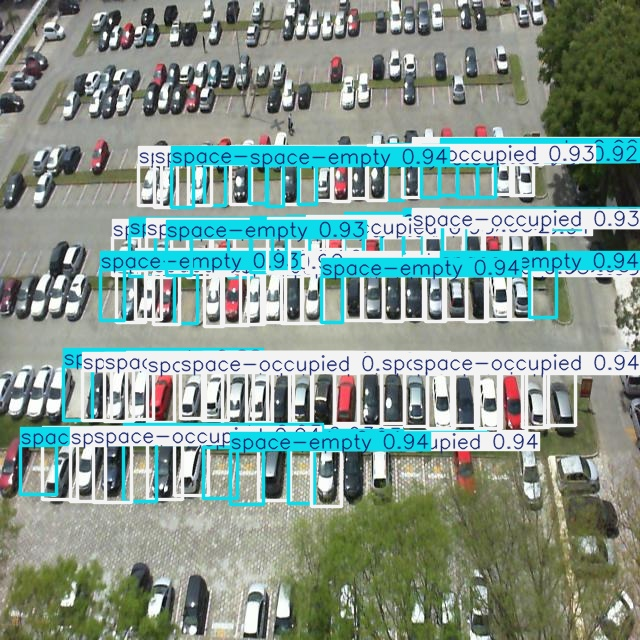

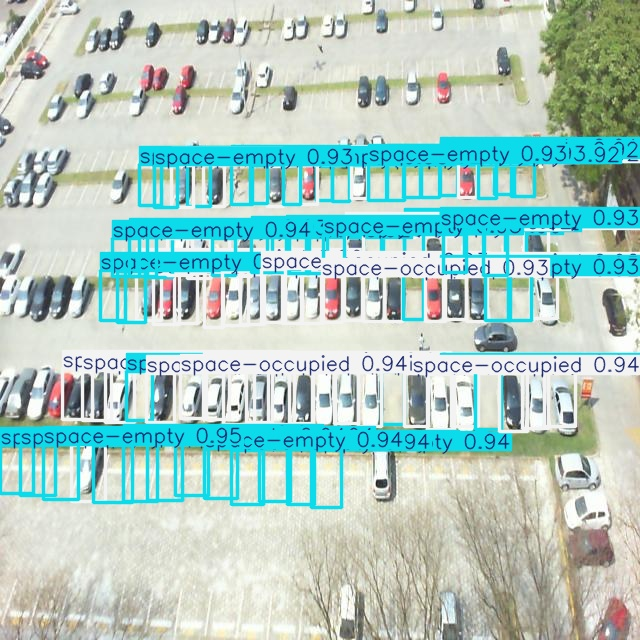

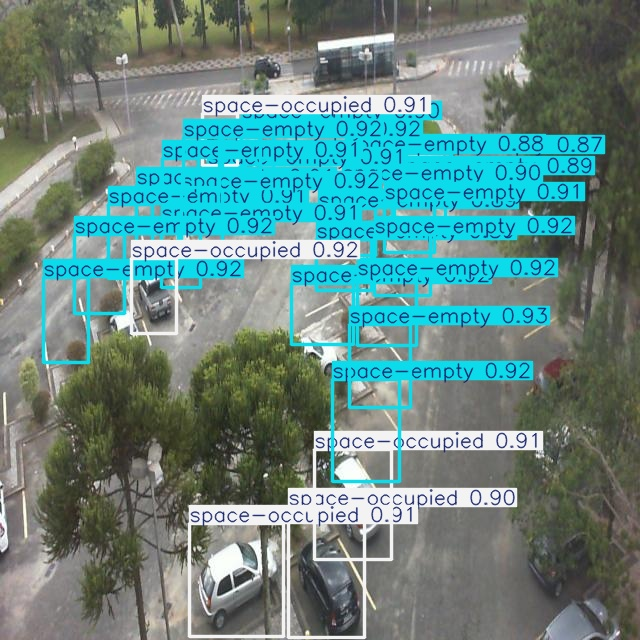

In [ ]:
import os
from IPython.display import Image, display

# 예측 결과 디렉토리 (마지막 predict 경로 자동 감지)
pred_dir = sorted([d for d in os.listdir("/content/runs/detect") if d.startswith("predict")])[-1]
pred_path = os.path.join("/content/runs/detect", pred_dir)

# 예측된 상위 3개 이미지 표시
pred_images = [f for f in os.listdir(pred_path) if f.endswith(".jpg")][:3]

for img_name in pred_images:
    display(Image(filename=os.path.join(pred_path, img_name), width=800))


In [27]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 원하는 경로로 저장
!cp /content/runs/detect/train/weights/best.pt /content/drive/MyDrive/best_parking_model.pt

print("✅ Google Drive에 모델 저장 완료")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive에 모델 저장 완료



image 1/1 /content/pklot_yolo/images/test/2012-10-16_11_43_37_jpg.rf.22327ebbbb6c13c9f9a9ad1d18fd4129.jpg: 640x640 29 space-emptys, 71 space-occupieds, 11.1ms
Speed: 2.4ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/pklot_yolo/images/test/2012-09-18_13_40_07_jpg.rf.c18cd85b25b56429ee268598b2564c8a.jpg: 640x640 52 space-emptys, 49 space-occupieds, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/pklot_yolo/images/test/2013-01-18_17_30_13_jpg.rf.1632c7e410b916d84eb56703744bbcea.jpg: 640x640 23 space-emptys, 5 space-occupieds, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/pklot_yolo/images/test/2013-01-18_17_30_13_jpg.rf.1632c7e410b916d84eb56703744bbcea.jpg: 640x640 23 space-emptys, 5 space-occupieds, 7.9ms
Speed: 1.7ms preprocess, 7.9ms inference, 1.4ms postprocess per image at sha

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53468 (\N{HANGUL SYLLABLE TAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

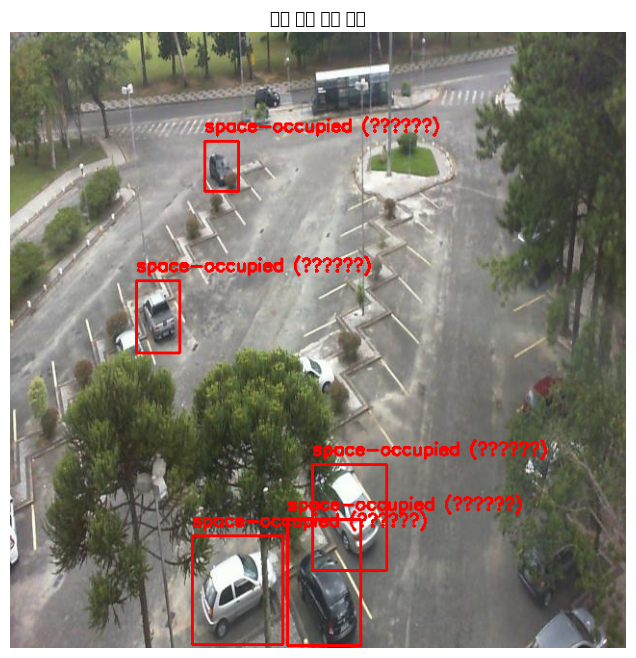

In [ ]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from ultralytics import YOLO

# 모델 로드
model = YOLO("/content/runs/detect/train/weights/best.pt")

# 이미지 선택 (한 장 또는 여러 장 반복 가능)
for img_name in test_images[:3]:  # 상위 3장만
    img_path = os.path.join(test_image_dir, img_name)
    results = model.predict(img_path, conf=0.4)[0]

# 예측
results = model.predict(img_path, conf=0.4)[0]  # [0] → 첫 번째 이미지 결과

# 원본 이미지 불러오기
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for box in results.boxes:
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
    cls = int(box.cls[0].item())
    label = results.names[cls]

    if label != 'space-occupied':
        continue  # 주차된 차량만 판단

    w = x2 - x1
    h = y2 - y1
    angle_deg = np.arctan2(h, w) * 180 / np.pi

    # 기준 기울기에서 얼마나 벗어났는지 판단 (예: 세로 기준 90도에서 ±15도 이상이면 삐뚤)
    deviation = abs(angle_deg - 90)
    if deviation > 15:
        judgment = "삐뚤"
        color = (255, 0, 0)  # Red
    else:
        judgment = "정상"
        color = (0, 255, 0)  # Green

    # 사각형 및 라벨 그리기
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
    cv2.putText(img, f"{label} ({judgment})", (int(x1), int(y1)-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# 결과 시각화
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title("주차 상태 판단 결과")
plt.show()
